# Modelos de predicción

<ul>
<li> Autores: Pablo Carretero Collado y Ramón Guerrero Morales</li>
<li> Fecha: 16/12/2021</li>
<li> Email: pablo.carretero@cunef.edu y ramon.guerrero@cunef.edu</li>
<li> Centro: CUNEF Universidad</li>    
</ul>

## Librerias

In [1]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, plot_confusion_matrix, accuracy_score
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import joblib
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import svm
import lightgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import sys
import pickle
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Importación de datos 

In [2]:
collision_xtrain_scaled= pd.read_csv('collision_xtrain_SMOTE.csv')
collision_ytrain= pd.read_csv('collision_ytrain_SMOTE.csv')
collision_xtest_scaled= pd.read_csv("collision_xtest_SMOTE.csv")
collision_ytest= pd.read_csv("collision_ytest_SMOTE.csv")

## Selección de variable Lasso

La regresion lasso (penalización L1) acepta coeficientes que sean 0 y si no se especifican parámetros, en este caso se queda con todas las variables cuyo coeficiente no sea cero. Para limitar el número de variables es necesario poner valor a los parámetros.  
Lo que la Lasso consigue es que algunos coeficientes sean exactamente cero excluyendo así a los predictores menos influyentes para el modelo, por lo que realiza selección de variables para la predicción.

### LASSO

In [3]:
start_l = time.time()

sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear',random_state = 0),
                            threshold = 0.025)
sel_lasso = sel_lasso.fit(collision_xtrain_scaled, collision_ytrain)

end_l = time.time()

print("El tiempo de ejecucion para lasso es:", end_l-start_l)

/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El tiempo de ejecucion para lasso es: 10.495149850845337


### Guardamos el Lasso con Pickle

In [4]:
filename_lasso = 'finalized_lasso.sav'
pickle.dump(sel_lasso, open(filename_lasso, 'wb'))

### Cargamos el Lasso con Pickle

In [5]:
filename_lasso = 'finalized_lasso.sav'
sel_lasso = pickle.load(open(filename_lasso, 'rb'))

In [6]:
sel_lasso.get_support()
selected_feat_lasso = collision_xtrain_scaled.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'C_V_YEARS', 'cos_C_HOUR',
       'sin_C_HOUR', 'cos_C_MNTH', 'sin_C_MNTH', 'cos_C_WDAY', 'sin_C_WDAY'],
      dtype='object')

In [7]:
print('total features: {}'.format((collision_xtrain_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 20
selected features: 18


In [8]:
collision_xtrain_scaled[selected_feat_lasso].shape

(3998415, 18)

In [9]:
collision_xtrain_l = collision_xtrain_scaled[selected_feat_lasso]
collision_xtest_l = collision_xtest_scaled[selected_feat_lasso]

In [10]:
collision_ytest = collision_ytest['C_SEV']

### Exportamos a CSV 

In [11]:
collision_xtest_l.to_csv('collision_xtest_l.csv',header=True, index=False)

In [12]:
collision_xtrain_l.to_csv('collision_xtrain_l.csv',header=True, index=False)

## Modelo GLM

El GLM es un modelo lineal genaralizado que permite que hayan variables respuesta que tienen modelos de distribución de errores distintos de una distribución normal.  
Generaliza la regresión lineal al permitir que el modelo lineal esté relacionado con la variable de respuesta a través de una función de enlace y al permitir que la magnitud de la varianza de cada medición sea una función de su valor predicho.

### Modelos binomiales de respuesta

In [13]:
start_glm = time.time()

glm_binom = sm.GLM(collision_ytrain, collision_xtrain_l, family = sm.families.Binomial())
res = glm_binom.fit()

end_glm = time.time()

print("El tiempo de ejecucion para GLM es:", end_glm-start_glm)

El tiempo de ejecucion para GLM es: 14.74360203742981


### Guardamos GLM con Pickle

In [14]:
filename_glm = 'finalized_glm.sav'
pickle.dump(res, open(filename_glm, 'wb'))

### Cargamos GLM

In [15]:
res = pickle.load(open(filename_glm, 'rb'))

### Vemos un resumen del modelo

In [16]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  C_SEV   No. Observations:              3998415
Model:                            GLM   Df Residuals:                  3998397
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5961e+06
Date:                Sun, 19 Dec 2021   Deviance:                   5.1921e+06
Time:                        17:38:01   Pearson chi2:                 4.08e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            -0.2438
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C_VEHS         0.0653      0.001     46.433      0.0

In [17]:
print('Numero de pruebas:', collision_ytrain.sum())
print('Parametros: ', res.params)
print('valores-T: ', res.tvalues)

Numero de pruebas: C_SEV    922711
dtype: int64
Parametros:  C_VEHS        0.065349
C_CONF        0.303942
C_RCFG        0.033198
C_WTHR        0.016608
C_RALN        0.039454
C_TRAF        0.076290
V_TYPE        0.087788
P_SEX         0.053742
P_AGE         0.092048
P_PSN         0.033123
P_SAFE        0.189889
C_V_YEARS    -0.040650
cos_C_HOUR    0.058198
sin_C_HOUR    0.021565
cos_C_MNTH   -0.038399
sin_C_MNTH   -0.033929
cos_C_WDAY    0.029212
sin_C_WDAY   -0.021412
dtype: float64
valores-T:  C_VEHS         46.433315
C_CONF        308.864104
C_RCFG         26.164139
C_WTHR         16.041503
C_RALN         37.183555
C_TRAF         59.019960
V_TYPE         90.077865
P_SEX          50.143290
P_AGE          90.901759
P_PSN          31.651214
P_SAFE        199.382941
C_V_YEARS     -38.106950
cos_C_HOUR     54.960141
sin_C_HOUR     20.264328
cos_C_MNTH    -36.175772
sin_C_MNTH    -32.080129
cos_C_WDAY     27.866934
sin_C_WDAY    -20.306982
dtype: float64


In [18]:
glm_prediction = res.predict(collision_xtest_l)

In [19]:
comparacion_glm = pd.DataFrame({'Actual': collision_ytest, 'Predicted': glm_prediction})
comparacion_glm

,Actual,Predicted
0,0,0.475488
1,0,0.787119
2,0,0.491200
3,0,0.735707
4,0,0.695888
...,...,...
1340362,0,0.442464
1340363,0,0.669890
1340364,0,0.412155
1340365,0,0.642473


In [20]:
clasificacionGLM = np.where(glm_prediction < 0.5,0,1)

In [21]:
comparacion_glm = pd.DataFrame({'Actual': collision_ytest, 'Predicted': clasificacionGLM})
comparacion_glm

,Actual,Predicted
0,0,0
1,0,1
2,0,0
3,0,1
4,0,1
...,...,...
1340362,0,0
1340363,0,1
1340364,0,0
1340365,0,1


### Obtenemos el error

In [22]:
print('Mean Absolute Error:', metrics.mean_absolute_error(collision_ytest, glm_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(collision_ytest, glm_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(collision_ytest, glm_prediction)))

Mean Absolute Error: 0.49110576674105205
Mean Squared Error: 0.2532549524292071
Root Mean Squared Error: 0.5032444261283051


### Métricas 

En este apartado de métricas obtendremos tanto la curva ROC, matriz de confusión(normalizada y sin normalizar), la curva de ganancia y lift (excepto en GLM) y por último el recall, f-score y la precisión.

Aprovechando que es el primer modelo explicaremos sólo en este qué son cada tipo de métricas que utilizaremos posteriormente para elegir el mejor modelo para optimizarlo.

#### Curva ROC

La interpretación de este gráfico es la representación de la proporción de verdaderos positivos frente a la proporción de falsos positivos.

In [23]:
auc = metrics.roc_auc_score(collision_ytest, glm_prediction)
print('AUC: %.3f' % auc)

AUC: 0.818


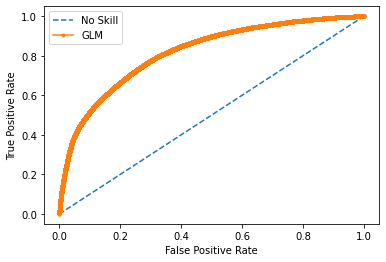

In [24]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, glm_prediction)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='GLM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

#### Matriz de confusión 

La matriz de confusión es una herramienta muy útil para valorar cómo de bueno es un modelo clasificación en machine learning. En particular, sirve para mostrar cuándo una clase es confundida con otra.

Text(0.5, 1.0, 'Normalized confusion matrix')

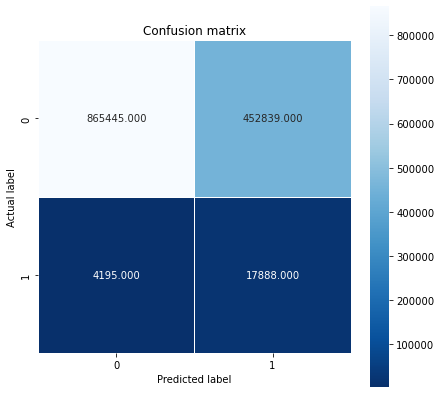

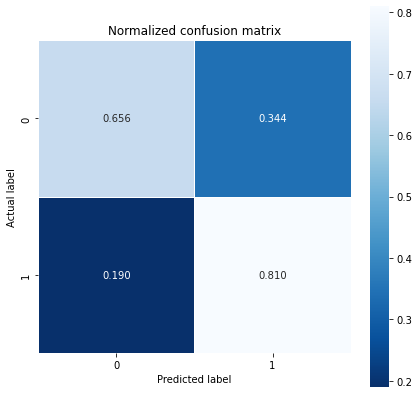

In [25]:
cm_gbt_gml= confusion_matrix(collision_ytest, clasificacionGLM)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, clasificacionGLM, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

#### F-Score

La F-Score es la medida de precisión que tiene un test.

In [26]:
score = f1_score(collision_ytest, clasificacionGLM)
score

0.07259592946571701

#### Recall

El Recall nos va a informar sobre la cantidad que el modelo de machine learning es capaz de identificar. 

In [92]:
Recall = recall_score(collision_ytest, clasificacionGLM)
Recall

0.8100348684508445

#### Precision

Con la métrica de precisión podemos medir la calidad del modelo de machine learning en tareas de clasificación.

In [93]:
Precision = precision_score(collision_ytest, clasificacionGLM)
Precision

0.038000794515717175

## Support Vector Machine

SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

In [27]:
start_svc = time.time()

clf = SGDClassifier(random_state=324, loss = 'log')
clf = clf.fit(collision_xtrain_l, collision_ytrain)

end_svc = time.time()

print("El tiempo de ejecucion para SVC es:", end_svc-start_svc)

/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El tiempo de ejecucion para SVC es: 7.432465076446533


### Guardamos SVC con Pickle

In [28]:
filename_svc = 'finalized_svc.sav'
pickle.dump(clf, open(filename_svc, 'wb'))

### Cargamos SVC con Pickle

In [29]:
clf = pickle.load(open(filename_svc, 'rb'))

### Vemos el modelo

In [30]:
SVC_prediction = clf.predict(collision_xtest_l)

In [31]:
SVC_prob_predictions = clf.predict_proba(collision_xtest_l)

In [32]:
clasificacion_svc = np.where(SVC_prediction < 0.5,0,1)

In [33]:
comparacion_svc = pd.DataFrame({'Actual': collision_ytest, 'Predicted': clasificacion_svc})
comparacion_svc

,Actual,Predicted
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
1340362,0,0
1340363,0,0
1340364,0,0
1340365,0,0


In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(collision_ytest, SVC_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(collision_ytest, SVC_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(collision_ytest, SVC_prediction)))

Mean Absolute Error: 0.06740019711019445
Mean Squared Error: 0.06740019711019445
Root Mean Squared Error: 0.2596154793347162


In [35]:
auc = metrics.roc_auc_score(collision_ytest, SVC_prediction)
print('AUC: %.3f' % auc)

AUC: 0.684


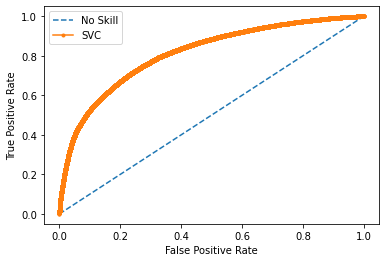

In [36]:
# keep probabilities for the positive outcome only
yhat_svc = SVC_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, yhat_svc)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

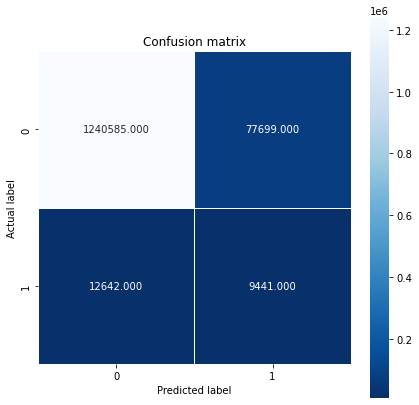

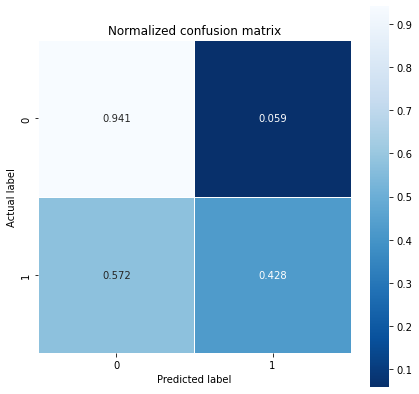

In [37]:
cm_gbt_gml= confusion_matrix(collision_ytest, SVC_prediction)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, SVC_prediction, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

#### Curva de Ganancia

El gráfico de ganancias acumuladas muestra el porcentaje del número total de casos en una categoría determinada al apuntar a un porcentaje del número total de casos.

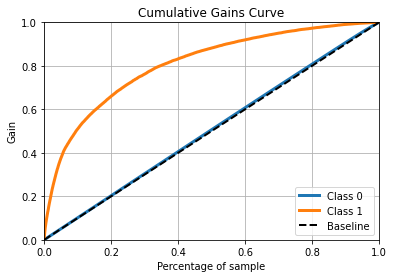

In [97]:
skplt.metrics.plot_cumulative_gain(collision_ytest, SVC_prob_predictions)
plt.show()

#### Curva Lift

La curva lift utiliza la probabilidad devuelta por el modelo para evaluar cómo se está desempeñando nuestro modelo y qué tan bien está identificando las instancias positivas o negativas de nuestro conjunto de datos.

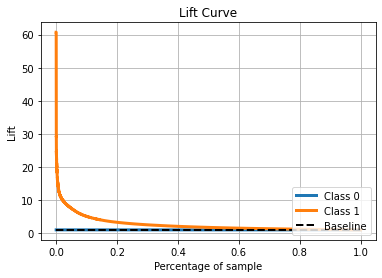

In [98]:
skplt.metrics.plot_lift_curve(collision_ytest, SVC_prob_predictions)
plt.show()

In [38]:
score = f1_score(collision_ytest, clasificacion_svc)
score

0.17287567636853043

In [99]:
Recall = recall_score(collision_ytest, SVC_prediction)
Recall

0.42752343431598966

In [100]:
Precision = precision_score(collision_ytest, SVC_prediction)
Precision

0.10834289648840946

## Random Forest

Un Random Forest es un conjunto de árboles de decisión combinados con bagging.  
Al usar bagging distintos árboles ven distintas porciones de los datos. Ningún árbol ve todos los datos de entrenamiento. 
Esto hace que cada árbol se entrene con distintas muestras de datos para un mismo problema. De esta forma, al combinar sus resultados, unos errores se compensan con otros y tenemos una predicción que generaliza mejor.

In [39]:
start_rf = time.time()

modelo = RandomForestClassifier(n_jobs=-1,random_state=3442)

modelo = modelo.fit(collision_xtrain_l, collision_ytrain)

end_rf = time.time()

print("El tiempo de ejecucion para RF es:", end_rf-start_rf)

/var/folders/5z/7v432v8x71s77lfhl478h3p40000gn/T/ipykernel_3936/3627550035.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = modelo.fit(collision_xtrain_l, collision_ytrain)


El tiempo de ejecucion para RF es: 242.3841950893402


### Guardamos RF con Pickle

In [40]:
filename_rf = 'finalized_rf.sav'
pickle.dump(modelo, open(filename_rf, 'wb'))

### Cargamos RF con Pickle

In [41]:
modelo = pickle.load(open(filename_rf, 'rb'))

### Vemos el modelo

In [42]:
RF_prediction = modelo.predict(collision_xtest_l)

In [43]:
RF_prob_predictions = modelo.predict_proba(collision_xtest_l)

In [44]:
comparacion_rf = pd.DataFrame({'Actual': collision_ytest, 'Predicted': RF_prediction})
comparacion_rf

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1340362,0,0
1340363,0,0
1340364,0,0
1340365,0,0


In [45]:
print('Mean Absolute Error:', metrics.mean_absolute_error(collision_ytest, RF_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(collision_ytest, RF_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(collision_ytest, RF_prediction)))

Mean Absolute Error: 0.0148078847062036
Mean Squared Error: 0.0148078847062036
Root Mean Squared Error: 0.1216876522339206


In [46]:
auc = metrics.roc_auc_score(collision_ytest, RF_prediction)
print('AUC: %.3f' % auc)

AUC: 0.566


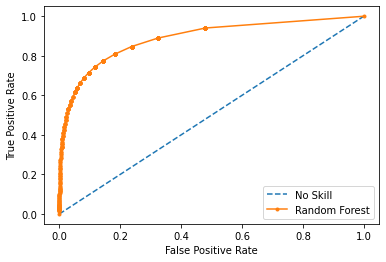

In [47]:
# keep probabilities for the positive outcome only
RF_yhat = RF_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, RF_yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

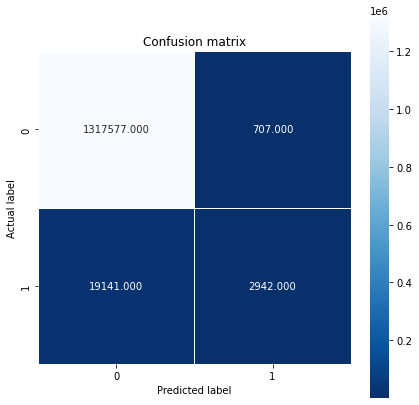

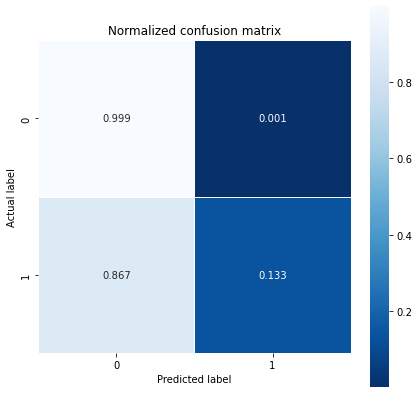

In [48]:
cm_gbt_rf= confusion_matrix(collision_ytest, RF_prediction)
cm_gbt_norm_rf = confusion_matrix(collision_ytest, RF_prediction, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_rf, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_rf, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

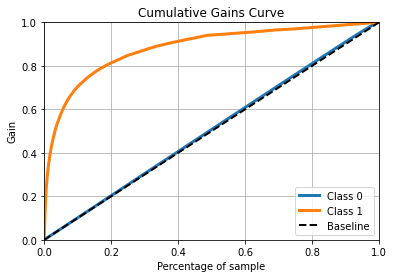

In [101]:
skplt.metrics.plot_cumulative_gain(collision_ytest, RF_prob_predictions)
plt.show()

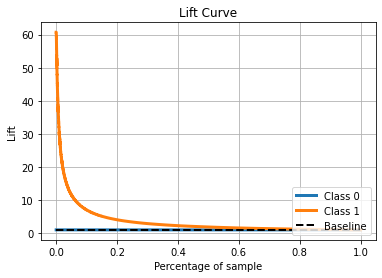

In [102]:
skplt.metrics.plot_lift_curve(collision_ytest, RF_prob_predictions)
plt.show()

In [49]:
score = f1_score(collision_ytest, RF_prediction)
score

0.22866469765272812

In [103]:
Recall = recall_score(collision_ytest, RF_prediction)
Recall

0.1332246524475841

In [104]:
Precision = precision_score(collision_ytest, RF_prediction)
Precision

0.8062482872019732

## XGBOOST

XGBoost es una implementación de árboles de decisión con Gradient boosting diseñada para minimizar la velocidad de ejecución y maximizar el rendimiento. Usa Boosting, un enfoque de machine learning basado en la idea de crear una regla de predicción altamente precisa combinando muchas reglas relativamente débiles e imprecisas. 

In [50]:
start_xgb = time.time()

clf_xgb = xgb.XGBClassifier(random_state=84848)
clf_xgb = clf_xgb.fit(collision_xtrain_l,collision_ytrain)

end_xgb = time.time()

print("El tiempo de ejecucion para XGB es:", end_xgb-start_xgb)

/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was 

[17:42:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
El tiempo de ejecucion para XGB es: 184.5130739212036


### Guardamos XGB con Pickle

In [51]:
filename_xgb = 'finalized_xgb.sav'
pickle.dump(clf_xgb, open(filename_xgb, 'wb'))

### Cargamos XGB con Pickle

In [52]:
clf_xgb = pickle.load(open(filename_xgb, 'rb'))

### Vemos el modelo

In [53]:
preds_xgb= clf_xgb.predict(collision_xtest_l)

In [54]:
XGB_prob_predictions = clf_xgb.predict_proba(collision_xtest_l)

In [106]:
auc = metrics.roc_auc_score(collision_ytest, preds_xgb)
print('AUC: %.3f' % auc)

AUC: 0.512


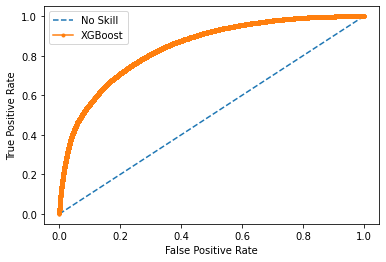

In [56]:
# keep probabilities for the positive outcome only
XGB_yhat = XGB_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, XGB_yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

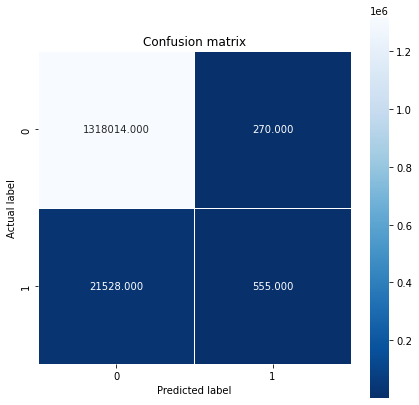

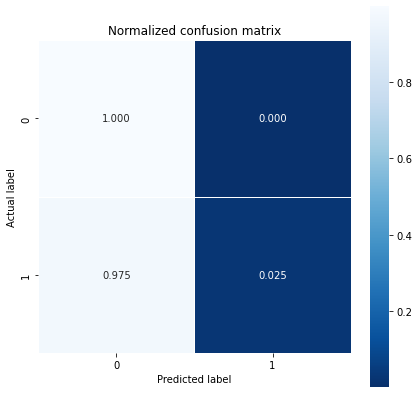

In [57]:
cm_gbt_gml= confusion_matrix(collision_ytest, preds_xgb)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, preds_xgb, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

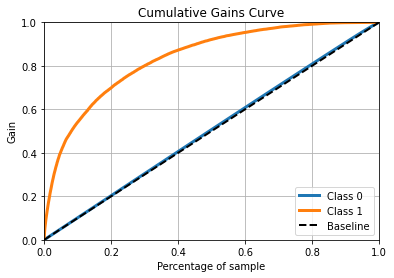

In [107]:
skplt.metrics.plot_cumulative_gain(collision_ytest, XGB_prob_predictions)
plt.show()

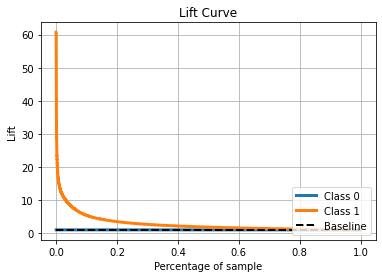

In [108]:
skplt.metrics.plot_lift_curve(collision_ytest, XGB_prob_predictions)
plt.show()

In [58]:
score = f1_score(collision_ytest, preds_xgb)
score

0.048454688318491354

In [109]:
Recall = recall_score(collision_ytest, preds_xgb)
Recall

0.02513245482950686

In [110]:
Precision = precision_score(collision_ytest, preds_xgb)
Precision

0.6727272727272727

## LightGBOOST

LightGBM es un algoritmo de refuerzo (o también de potenciación) de gradientes basado en modelos de árboles de decisión. 

In [59]:
start_lgbm = time.time()

model_lgbm = LGBMClassifier(random_state=2334)
model_lgbm = model_lgbm.fit(collision_xtrain_l, collision_ytrain)

end_lgbm = time.time()

print("El tiempo de ejecucion para lgbm es:", end_lgbm-start_lgbm)

/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El tiempo de ejecucion para lgbm es: 11.71943473815918


### Guardamos el modelo

In [60]:
filename_lgbm = 'finalized_lgbm.sav'
pickle.dump(model_lgbm, open(filename_lgbm, 'wb'))

### Cargamos el modelo

In [61]:
model_lgbm = pickle.load(open(filename_lgbm, 'rb'))

### Vemos el modelo

In [62]:
prediccion_lgbm = model_lgbm.predict(collision_xtest_l)

In [63]:
LGBM_prob_predictions = model_lgbm.predict_proba(collision_xtest_l)

In [64]:
accuracy_score(collision_ytest, prediccion_lgbm)

0.9835955376400642

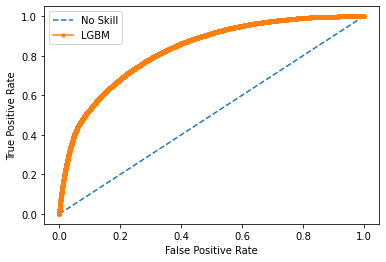

In [65]:
# keep probabilities for the positive outcome only
LGBM_yhat = LGBM_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, LGBM_yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

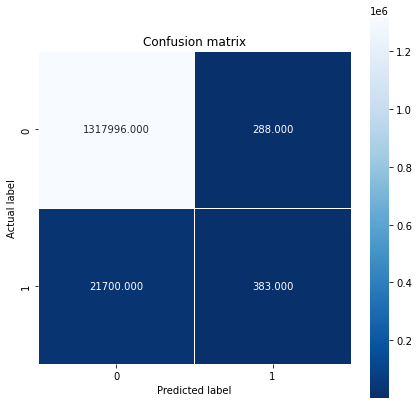

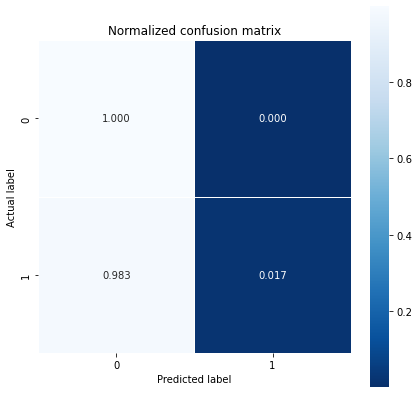

In [66]:
cm_gbt_gml= confusion_matrix(collision_ytest, prediccion_lgbm)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, prediccion_lgbm, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

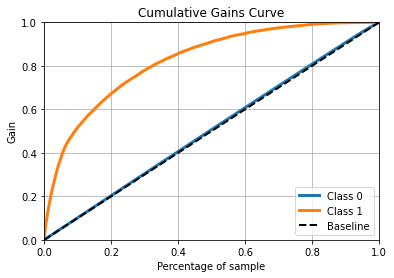

In [111]:
skplt.metrics.plot_cumulative_gain(collision_ytest, LGBM_prob_predictions)
plt.show()

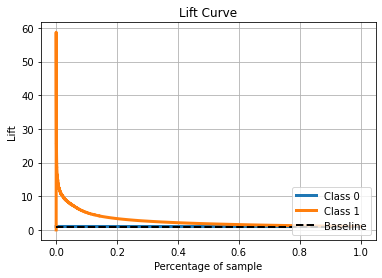

In [112]:
skplt.metrics.plot_lift_curve(collision_ytest, LGBM_prob_predictions)
plt.show()

In [67]:
score = f1_score(collision_ytest, prediccion_lgbm)
score

0.033664410653071984

In [113]:
Recall = recall_score(collision_ytest, prediccion_lgbm)
Recall

0.01734365801747951

In [114]:
Precision = precision_score(collision_ytest, prediccion_lgbm)
Precision

0.5707898658718331

# Hiperparámetros

Como mejor modelo elegimos el Random Forest dado que sus métricas nos parecen mejores que las de los demás modelos. 

Hemos observado que tiene unas mejores métricas recall, precisión y f-score además de tener una buena curva roc.  
Solo encontramos una mala matriz de confusión que intentaremos mejorar mediante la manipulación de los pesos dentro de los hiperparámetros. 

Por tanto, como es el mejor modelo que se adapta a nuestras exigencias pasaremos a su optimización.

In [68]:
### Parameter Tunning Optimization
start_rf_hiper = time.time()

param_grid = { 
    'n_estimators': [200],# poner tantos como se quiera probar
    'max_features': ['auto'], #['auto', 'sqrt', 'log2']
    'max_depth' : [4], # [4,5,6,7,8]
    'criterion':['gini'],#['gini', 'entropy',
    'class_weight' : [{0:0.6,1:1.8}]} 
    

CV = RandomizedSearchCV(modelo, param_grid, cv=3, random_state=6777, n_jobs = -1)
                  
CV = CV.fit(collision_xtrain_l, collision_ytrain)  

end_rf_hiper= time.time()

print("El tiempo de ejecucion para RF con hiperparámetros es:", end_rf_hiper-start_rf_hiper)

print(CV.best_params_)    
print(CV.best_score_)

/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/

El tiempo de ejecucion para RF con hiperparámetros es: 390.8093240261078
{'n_estimators': 200, 'max_features': 'auto', 'max_depth': 4, 'criterion': 'gini', 'class_weight': {0: 0.6, 1: 1.8}}
0.7628710376486683


### Guardamos el RF con hiperparámetros

In [69]:
filename_rf_hiper = 'finalized_rf_hiper.sav'
pickle.dump(CV, open(filename_rf_hiper, 'wb'))

### Cargamos RF con hiperparámetros con Pickle

In [70]:
filename_rf_hiper = 'finalized_rf_hiper.sav'
CV = pickle.load(open(filename_rf_hiper, 'rb'))

### Vemos el modelo

In [71]:
predictions_hiper = CV.predict(collision_xtest_l)

In [72]:
print("Classification Report")
print(classification_report(collision_ytest, predictions_hiper))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.75      0.86   1318284
           1       0.04      0.69      0.08     22083

    accuracy                           0.75   1340367
   macro avg       0.52      0.72      0.47   1340367
weighted avg       0.98      0.75      0.84   1340367



In [73]:
CV.best_estimator_.feature_importances_

array([9.63919900e-02, 3.82462403e-01, 9.51720584e-02, 7.19570419e-03,
       6.51366091e-02, 1.47146428e-01, 2.69847978e-02, 5.77697718e-03,
       4.12793868e-03, 2.36518982e-03, 1.39918075e-01, 8.39492556e-03,
       1.20251188e-02, 6.55458958e-03, 1.77223614e-04, 4.60403024e-05,
       9.21566960e-05, 3.17742664e-05])

In [74]:
prob_predictions = CV.predict_proba(collision_xtest_l)
prob_predictions

array([[0.66019125, 0.33980875],
       [0.36866902, 0.63133098],
       [0.79447568, 0.20552432],
       ...,
       [0.84113082, 0.15886918],
       [0.64083902, 0.35916098],
       [0.28700817, 0.71299183]])

In [75]:
Recall = recall_score(collision_ytest, predictions_hiper)
Recall

0.6910745822578453

In [76]:
Precision = precision_score(collision_ytest, predictions_hiper)
Precision

0.0444880420713861

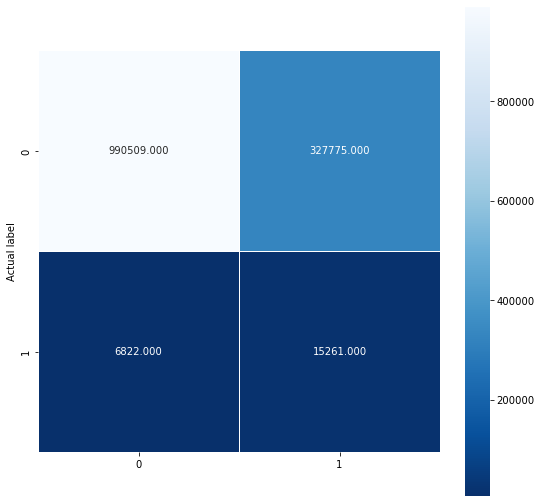

In [77]:
cm_gbt = confusion_matrix(collision_ytest, predictions_hiper)

plt.figure(figsize=(9,9))
sns.heatmap(cm_gbt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[990509 327775]
 [  6822  15261]]


/Users/ramonguerreromorales/opt/anaconda3/envs/Practica1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[0.75136238 0.24863762]
 [0.30892542 0.69107458]]


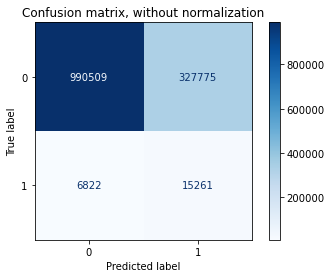

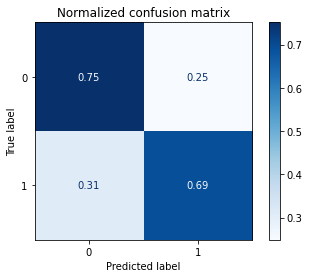

In [78]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(CV, collision_xtest_l, collision_ytest,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

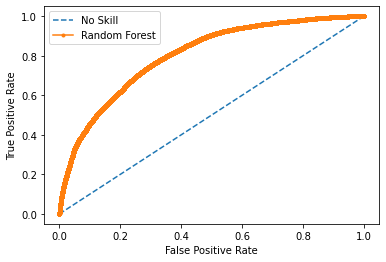

In [79]:
# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [116]:
auc = metrics.roc_auc_score(collision_ytest, predictions_hiper)
print('AUC: %.3f' % auc)

AUC: 0.721


In [80]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [81]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.472172, G-Mean=0.724


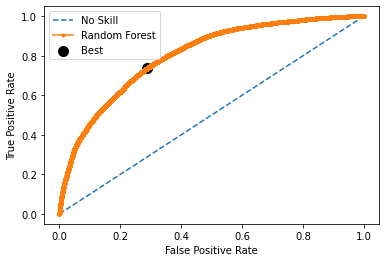

In [82]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [83]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(collision_ytest, yhat)

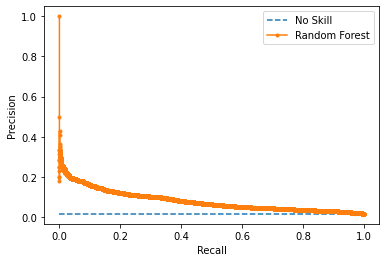

In [84]:
# plot the roc curve for the model
no_skill = len(collision_ytest[collision_ytest==1]) / len(collision_ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.641956, F-Score=0.154


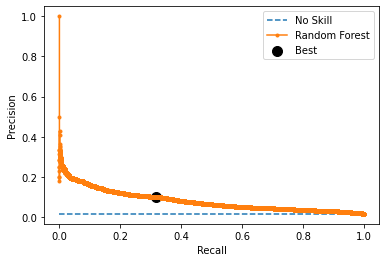

In [85]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(collision_ytest[collision_ytest==1]) / len(collision_ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [86]:
# evaluate the model
score = f1_score(collision_ytest, predictions_hiper)
print('F-Score: %.5f' % score)

F-Score: 0.08359


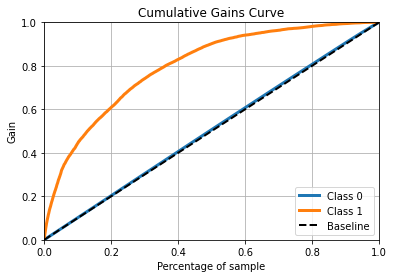

In [87]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(collision_ytest, prob_predictions)
plt.show()

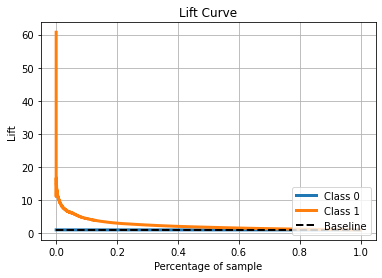

In [88]:
skplt.metrics.plot_lift_curve(collision_ytest, prob_predictions)
plt.show()

Finalmente hemos obtenido un buen modelo mediante la optimización del Random Forest, obteniendo incluso mejor curva roc y matriz de confusión. 

Nuestro modelo acierta los 0 en un 75% y los 1 en un 69% además de tener un score de 0.721 en la curva roc. 

En el siguiente notebook seguiremos con la interpretabilidad del modelo y sus variables.